In [2]:
import os
import sys
sys.path.append('../..')
import numpy as np
import deepbayesHF
import deepbayesHF.optimizers as optimizers
from deepbayesHF import PosteriorModel
from deepbayesHF.analyzers import FGSM
from deepbayesHF.analyzers import eps_LRP
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import cv2
import random
import matplotlib.pyplot as plt
from collections import namedtuple

from joblib import Parallel, delayed
import subprocess
from statistics import mode
import json

In [3]:
def display_number(X,SCALE):
    X = X.reshape(SCALE[0],SCALE[1])
    plt.imshow(X,cmap='gray')
    plt.show()
    
def display_explanation(x0,SCALE,expl):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3)
    x0_2d = x0.reshape(SCALE[0],SCALE[1])
    ax1.set_title('Input')
    ax1.imshow(x0_2d,cmap='gray')
    expl_2d = expl.reshape(SCALE[0],SCALE[1])
    ax2.set_title('Explanation')
    ax2.imshow(expl_2d)
    
    cmap = plt.cm.gray
    norm = plt.Normalize(x0.min(),x0.max())
    rgba = cmap(norm(x0))
    
    norm_ex = plt.Normalize(expl.min(),expl.max())
    normed_ex = norm_ex(expl)
    
    for i,x in enumerate(normed_ex):
        if x > 0:
            rgba[i] = x,0,0,1
    
    rgba = rgba.reshape(SCALE[0],SCALE[1],4)
    
    ax3.set_title('Overlayed')
    ax3.imshow(rgba,interpolation='nearest')
    plt.show()

In [4]:
# Load mnist data and scale down to SCALE (trying 14x14 initially)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
SCALE = (14,14)
if not SCALE == X_train[0].shape:
    X_train = np.array(list(map(lambda x:cv2.resize(x,SCALE,interpolation=cv2.INTER_CUBIC),X_train)))
X_train = X_train/255.
X_train = X_train.astype("float32").reshape(len(X_train), SCALE[0],SCALE[1])

if not SCALE == X_test.shape:
    X_test = np.array(list(map(lambda x:cv2.resize(x,SCALE,interpolation=cv2.INTER_CUBIC),X_test)))
X_test = X_test/255.
X_test = X_test.astype("float32").reshape(len(X_test), SCALE[0], SCALE[1])

# make it a binary classification task (X or not X)

target = 8
y_train = np.array([1 if y == target else 0 for y in y_train])
y_test = np.array([1 if y == target else 0 for y in y_test])

# filter so we get about 50% target class and 50% other
target_idxs = [i for i in range(len(y_train)) if y_train[i] == 1]
other_idxs = [i for i in range(len(y_train)) if y_train[i] == 0]

random.shuffle(other_idxs)
other_idxs = other_idxs[:len(target_idxs)]
# pick len(target_idxs) samples from the other_idxs
X_train = np.array([x for i,x in enumerate(X_train) if i in other_idxs or i in target_idxs])
y_train = np.array([y for i,y in enumerate(y_train) if i in other_idxs or i in target_idxs])

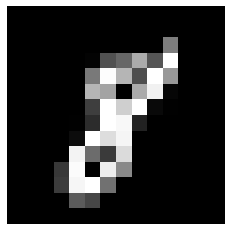

[[0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.49 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.00 0.00 0.01 0.32 0.40 0.67 0.33 1.00 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.00 0.00 0.47 0.99 0.71 0.31 1.00 0.60 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.00 0.00 0.71 0.64 0.00 0.67 0.95 0.02 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.00 0.00 0.24 1.00 0.81 1.00 0.04 0.00 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.00 0.00 0.18 1.00 0.97 0.13 0.00 0.00 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.00 0.05 1.00 0.87 0.96 0.00 0.00 0.00 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.00 0.96 0.42 0.23 0.86 0.00 0.00 0.00 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.22 0.98 0.00 0.93 0.54 0.00 0.00 0.00 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.24 0.96 1.00 0.45 0.00 0.00 0.00 0.00 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.00 0.36 0.27 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 ]
[ 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0

In [15]:
plt.imshow(X_train[0],cmap='gray')
plt.axis('off')
plt.show()
print('[',end='')
for idx,row in enumerate(X_train[0]):
    print('[',end='')
    if not idx == 0:
        print(' ',end='')
    for val in row:
        print(f'{val:.2f} ',end='')
    print(']',end='')
    if not idx == len(X_train[0])-1:
        print()
print(']')

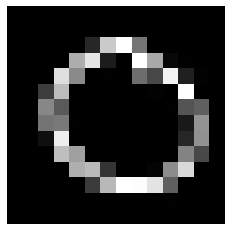

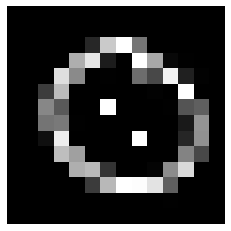

1.4142135


In [30]:
im = X_train[10]
plt.imshow(im,cmap='gray')
plt.axis('off')
plt.show()

im2 = im.copy()
im2[6][6] = 1
im2[8][8] = 1
plt.imshow(im2,cmap='gray')
plt.axis('off')
plt.show()

dist = np.linalg.norm(im2-im)
print(dist)

In [34]:
model_name = f'mnist{SCALE[0]}x{SCALE[1]}_32_16_binary_target{target}_thesistest'
opt = optimizers.VariationalOnlineGuassNewton()
likelihood = tf.keras.losses.SparseCategoricalCrossentropy()

inputs = Input(shape=X_train[0].shape)
tmp = Flatten()(inputs)
tmp = Dense(256,activation='relu')(tmp)
tmp = Dense(128,activation='relu')(tmp)
predictions = Dense(2,activation='softmax')(tmp)
model = Model(inputs=inputs,outputs=predictions)

bayes_model = opt.compile(model,loss_fn=likelihood,
                          epochs=25, learning_rate=0.25,
                          inflate_prior=2.0, log_file='tmp/log.txt')
bayes_model.train(X_train,y_train,X_test,y_test)
bayes_model.save(model_name)

  4%|▍         | 7/183 [00:00<00:02, 64.91it/s]

This optimizer does not have a default compilation method. Please make sure to call the correct .compile method before use.
deepbayes: Using implicit prior
(196, 256) 0.10101525445522107
(256, 128) 0.08838834764831845
(128, 2) 0.125
deepbayes: Using implicit prior
(196, 256) 0.10101525445522107
(256, 128) 0.08838834764831845
(128, 2) 0.125


  4%|▍         | 8/183 [00:00<00:02, 79.24it/s]

Epoch 1, loss: 0.575, acc: 0.697, val_loss: 0.376, val_acc: 0.851


  4%|▍         | 7/183 [00:00<00:02, 68.77it/s]

Epoch 2, loss: 0.331, acc: 0.869, val_loss: 0.503, val_acc: 0.811


  3%|▎         | 6/183 [00:00<00:03, 54.79it/s]

Epoch 3, loss: 0.263, acc: 0.900, val_loss: 0.273, val_acc: 0.891


  5%|▍         | 9/183 [00:00<00:02, 80.46it/s]

Epoch 4, loss: 0.216, acc: 0.916, val_loss: 0.214, val_acc: 0.913


  4%|▍         | 8/183 [00:00<00:02, 73.48it/s]

Epoch 5, loss: 0.199, acc: 0.925, val_loss: 0.172, val_acc: 0.934


  4%|▍         | 8/183 [00:00<00:02, 74.76it/s]

Epoch 6, loss: 0.181, acc: 0.933, val_loss: 0.258, val_acc: 0.903


  3%|▎         | 5/183 [00:00<00:03, 48.09it/s]

Epoch 7, loss: 0.137, acc: 0.949, val_loss: 0.109, val_acc: 0.957


  5%|▍         | 9/183 [00:00<00:02, 82.26it/s]

Epoch 8, loss: 0.111, acc: 0.962, val_loss: 0.121, val_acc: 0.952


  5%|▍         | 9/183 [00:00<00:02, 81.69it/s]

Epoch 9, loss: 0.093, acc: 0.968, val_loss: 0.125, val_acc: 0.953


  5%|▍         | 9/183 [00:00<00:02, 83.33it/s]

Epoch 10, loss: 0.084, acc: 0.970, val_loss: 0.117, val_acc: 0.958


  3%|▎         | 6/183 [00:00<00:03, 56.62it/s]

Epoch 11, loss: 0.073, acc: 0.973, val_loss: 0.110, val_acc: 0.961


  5%|▍         | 9/183 [00:00<00:02, 82.53it/s]

Epoch 12, loss: 0.066, acc: 0.977, val_loss: 0.123, val_acc: 0.958


  4%|▍         | 8/183 [00:00<00:02, 78.90it/s]

Epoch 13, loss: 0.060, acc: 0.979, val_loss: 0.125, val_acc: 0.956


  4%|▍         | 7/183 [00:00<00:02, 61.59it/s]

Epoch 14, loss: 0.059, acc: 0.980, val_loss: 0.057, val_acc: 0.980


  5%|▍         | 9/183 [00:00<00:02, 84.16it/s]

Epoch 15, loss: 0.053, acc: 0.979, val_loss: 0.032, val_acc: 0.989


  4%|▍         | 8/183 [00:00<00:02, 74.33it/s]

Epoch 16, loss: 0.044, acc: 0.984, val_loss: 0.084, val_acc: 0.970


  5%|▍         | 9/183 [00:00<00:02, 72.85it/s]

Epoch 17, loss: 0.039, acc: 0.986, val_loss: 0.060, val_acc: 0.979


  5%|▍         | 9/183 [00:00<00:02, 80.81it/s]

Epoch 18, loss: 0.037, acc: 0.987, val_loss: 0.035, val_acc: 0.987


  4%|▍         | 7/183 [00:00<00:02, 60.10it/s]

Epoch 19, loss: 0.032, acc: 0.989, val_loss: 0.093, val_acc: 0.969


  4%|▍         | 7/183 [00:00<00:02, 68.44it/s]

Epoch 20, loss: 0.030, acc: 0.988, val_loss: 0.036, val_acc: 0.987


  4%|▍         | 8/183 [00:00<00:02, 71.95it/s]

Epoch 21, loss: 0.023, acc: 0.992, val_loss: 0.068, val_acc: 0.977


  3%|▎         | 6/183 [00:00<00:03, 53.78it/s]

Epoch 22, loss: 0.020, acc: 0.992, val_loss: 0.052, val_acc: 0.982


  4%|▍         | 8/183 [00:00<00:02, 70.74it/s]

Epoch 23, loss: 0.018, acc: 0.994, val_loss: 0.042, val_acc: 0.985


  4%|▍         | 8/183 [00:00<00:02, 64.51it/s]

Epoch 24, loss: 0.015, acc: 0.994, val_loss: 0.070, val_acc: 0.979


  4%|▍         | 7/183 [00:00<00:02, 68.02it/s]

Epoch 25, loss: 0.013, acc: 0.996, val_loss: 0.044, val_acc: 0.985


100%|██████████| 183/183 [00:02<00:00, 65.90it/s]


Epoch 26, loss: 0.011, acc: 0.997, val_loss: 0.079, val_acc: 0.977
('batch_size', 64)
('learning_rate', 0.25)
('decay', 0.0)
('epochs', 26)
('inflate_prior', 2.0)
('input_noise', 0.0)
('robust_train', 0)
('epsilon', 0.1)
('robust_lambda', 0.5)
('loss_monte_carlo', 2)
('input_upper', inf)
('input_lower', -inf)
('beta_1', 0.999)
('beta_2', 0.9999)
('lam', 1.0)
('N', 11702)
('max_eps', 0.1)
('max_robust_lambda', 0.5)


In [35]:
model_name = f'mnist{SCALE[0]}x{SCALE[1]}_32_16_binary_target{target}_thesistest'
bayes_model = PosteriorModel(model_name)
y_pred = bayes_model.predict(X_test,n=50)
check_accuracy = tf.keras.metrics.Accuracy(name="train_acc")
check_accuracy(y_test,np.argmax(y_pred,axis=1))
print()
print('Loaded model accuracy:',f'{check_accuracy.result().numpy()*100:.2f}%')

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 14, 14)]          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 196)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               50432     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 258       
Total params: 83,586
Trainable params: 83,586
Non-trainable params: 0
_________________________________________________________________
deepbayes: detected the above model 
 None

Loaded model accuracy: 96.56%


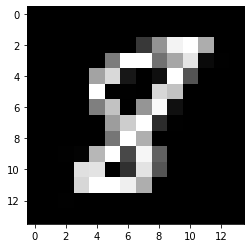

Prediction: Not eight.


In [48]:
N = 50
# pick a random positive input for testing
n = 0
for i in range(11235,len(y_train)):
    if y_train[i] == 1:
        n = i
        break

X = X_train[n].reshape(1,SCALE[0],SCALE[1]).astype(np.float32)
y_hat = np.argmax(bayes_model.predict(X,n=N))
y_class = 'Eight.' if y_hat == 1 else 'Not eight.'
display_number(X,SCALE)
print('Prediction:',y_class)
input_shape = X.flatten().shape

In [49]:
sys.path.append("../GTSRB/LayerwiseRelevancePropagation/src")
from lrp import RelevancePropagation
bayes_model.set_weights(bayes_model.sample())
X = X.reshape(1,SCALE[0],SCALE[1])
y = np.argmax(np.array(bayes_model._predict(X)).flatten())

lrp = RelevancePropagation(0.01,'max',True,X.shape,bayes_model.model)
exp = lrp.run(X)
print(exp)

dense_18
dense_17
dense_16
flatten_1
input_8
(1, 14, 14)
[0.00000000e+00 0.00000000e+00 7.03198323e-01 8.41634334e-01
 6.07175265e-01 4.21925643e-01 6.85384600e-01 7.52185648e-01
 6.01189255e-01 9.74530187e-01 6.34470027e-01 1.00000000e+00
 4.23366831e-04 0.00000000e+00]


In [14]:
# THIS TAKES ~ 5 mins
input_path = 'X_thesis.npy'
y_path = 'y_thesis.npy'
output_path = f'exps/exps_thesis{n}'
if not os.path.exists(output_path):
    os.mkdir(output_path)
np.save(os.path.join(output_path,input_path),X,False)
np.save(os.path.join(output_path,y_path),y_hat,False)

iterations = 20
for i in range(iterations):
    subprocess.Popen(['python3','get_mnist_exp.py',str(i),model_name,os.path.join(output_path,input_path),output_path])
    
full = False 
while not full:
    if len([name for name in os.listdir(output_path) if os.path.isfile(os.path.join(output_path, name))]) == iterations+1:
        full = True

KeyboardInterrupt: 

In [6]:
# read in and display the results from the above
exps = []
for f in os.listdir('exps'):
    if os.path.isfile(os.path.join('exps',f)):
        tmp = np.load(os.path.join('exps',f))
        exps.append(tmp)

In [1]:
np_exps = np.array(exps)

new_exps = np_exps

merged = sum(new_exps)/len(new_exps)

mexp = merged[0]
pos = np.zeros(input_shape)
neg = np.zeros(input_shape)

clip_val = 100000

if(y_hat == 0):
    pos += np.squeeze(np.clip(mexp, 0, clip_val))
    neg += -1*np.squeeze(np.clip(mexp, -clip_val, 0))
elif(y_hat == 1):
    neg += np.squeeze(np.clip(mexp, 0, clip_val))
    pos += -1*np.squeeze(np.clip(mexp, -clip_val, 0))
    
display_number(X.flatten(),SCALE)
expl = pos if y_hat == 0 else neg
display_explanation(X.flatten(),SCALE,expl)

NameError: name 'np' is not defined

In [8]:
uncert_Xs = []
uncert_Ypredarrs = []
uncert_ytruth = []
for idx,xt in enumerate(X_test):
    if idx%100 == 0:
        print('step',idx)
    s_len = len(uncert_Xs)
    Xt_one = np.array([xt])
    y_preds = []
    n = 50
    truth = y_test[idx]
    for i in range(n):
        bayes_model.model.set_weights(bayes_model.sample())
        y_preds.append(bayes_model.model(Xt_one))

    #print(y_preds)
    argmax = list(map(np.argmax,y_preds))
    try:
        m = mode(argmax)
        if not argmax.count(m) >= len(argmax)-(n/2):
            uncert_Xs.append(list(map(float,xt)))
            uncert_Ypredarrs.append([list(map(float,yp[0])) for yp in y_preds])
            uncert_ytruth.append(int(truth))
    except:
        uncert_Xs.append(list(map(float,xt)))
        uncert_Ypredarrs.append([list(map(float,yp[0])) for yp in y_preds])
        uncert_ytruth.append(int(truth))

    if len(uncert_Xs) > s_len:
        print(len(uncert_Xs))
    if len(uncert_Xs) > 4:
        break
        
to_file_entries = []
for idx,uyp in enumerate(uncert_Ypredarrs):
    entry = dict()
    entry['input'] = uncert_Xs[idx]
    entry['y'] = uncert_ytruth[idx]
    entry['y_pred_arrs'] = uyp
    entry['y_preds'] = list(map(int,list(map(np.argmax,uyp))))
    to_file_entries.append(entry)
    print(list(map(np.argmax,uyp)))

# save uncert inputs to file

with open('uncert_data/uncert_mnist.json','w') as f:
    json.dump(to_file_entries,f)
    

step 0
step 100
step 200
step 300


KeyboardInterrupt: 

In [102]:
# TAKES A WHILE TO RUN (~5 MINS)

uncert_idx = 3

uncert_dict = None
with open('uncert_data/uncert_mnist.json','r') as f:
    uncert_dict = json.load(f)
    
if uncert_idx > len(uncert_dict):
    print('No data at this index.')
    
uncert_X = np.asarray(uncert_dict[uncert_idx]['input']).reshape(1,SCALE[0]*SCALE[1]).astype(float)
uncert_y = uncert_dict[uncert_idx]['y']

input_path = 'X_uncert.npy'
y_path = 'y_uncert.npy'
output_path = f'exps/exps_uncert{uncert_idx}'
if not os.path.exists(output_path):
    os.mkdir(output_path)
np.save(os.path.join(output_path,input_path),uncert_X,False)
np.save(os.path.join(output_path,y_path),uncert_y,False)

iterations = 20
for i in range(iterations):
    subprocess.Popen(['python3','get_mnist_exp.py',str(i),model_name,os.path.join(output_path,input_path),output_path])
    
full = False 
while not full:
    if len([name for name in os.listdir(output_path) if os.path.isfile(os.path.join(output_path, name))]) == iterations+1:
        full = True
    

Input image (ground truth = 0 Negative (it's not an 8)):


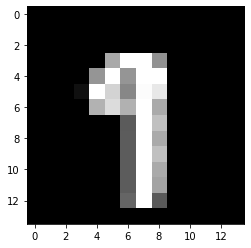

Positive explanation (contributes to class 0):


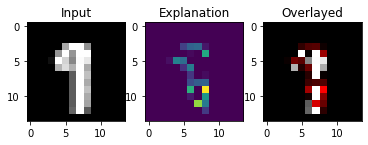

Negative explanation (contributes against class 0):


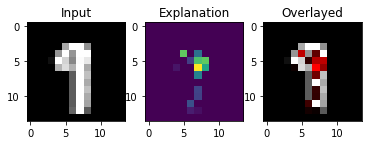


Sanity checking
---------------
Index in X_test: 1554
Classification in y_test: 0


In [11]:
# read in and display the results from an uncert input

input_num = 1
input_path = 'X_uncert.npy'
output_path = f'exps/exps_uncert{input_num}'
y_path = 'y_uncert.npy'


exps = []
for f in os.listdir(output_path):
    if os.path.isfile(os.path.join(output_path,f)) and not f.startswith('X') and not f.startswith('y'):
        tmp = np.load(os.path.join(output_path,f))
        exps.append(tmp)
        
uncert_X = np.load(os.path.join(output_path,input_path))
uncert_y = np.load(os.path.join(output_path,y_path))

input_shape = uncert_X.flatten().shape
        
np_exps = np.array(exps)

new_exps = np_exps

merged = sum(new_exps)/len(new_exps)

mexp = merged[0]
pos = np.zeros(input_shape)
neg = np.zeros(input_shape)

clip_val = 100000

if(uncert_y == 0):
    pos += np.squeeze(np.clip(mexp, 0, clip_val))
    neg += -1*np.squeeze(np.clip(mexp, -clip_val, 0))
elif(uncert_y == 1):
    neg += np.squeeze(np.clip(mexp, 0, clip_val))
    pos += -1*np.squeeze(np.clip(mexp, -clip_val, 0))

act_class = "Positive (it's an 8)" if uncert_y > 0 else "Negative (it's not an 8)" 
print(f'Input image (ground truth = {uncert_y} {act_class}):')
display_number(uncert_X.flatten(),SCALE)
print(f'Positive explanation (contributes to class {uncert_y}):')
display_explanation(uncert_X.flatten(),SCALE,pos)
print(f'Negative explanation (contributes against class {uncert_y}):')
display_explanation(uncert_X.flatten(),SCALE,neg)
print()
print('Sanity checking')
print('---------------')
for idx,xt in enumerate(X_test):
    if list(uncert_X.flatten()) == list(map(float,xt)):
        print('Index in X_test:',idx)
        print('Classification in y_test:',y_test[idx])

In [ ]:
# want to find: average bayesian explanation of an 8

# train on just 1's and 9's, give it a 7 (look at prediction for both 1 and 9, hope we see corresponding parts)

# pick another good explanation method